## <b> Лабораторна робота №2
"Метрики"\
Виконала: Челюскіна Юлія КМ-21 (2-га підгрупа)

---

## Початкові дані (1)

In [161]:
import pandas as pd
df  = pd.read_csv("KM-21-2.csv", delimiter=",")
df



,GT,Model_1_0,Model_2_1
0,1,0.014745,0.996526
1,0,0.999735,0.003289
2,0,0.999786,0.125449
3,0,0.999695,0.000858
4,1,0.022115,0.786606
...,...,...,...
4395,0,0.999753,0.125449
4396,0,0.999777,0.125449
4397,0,0.909023,0.159557
4398,0,0.999737,0.125999


## Збалансованість (2)


In [17]:
df.describe()

,GT,Model_1_0,Model_2_1
count,4400.000000,4400.000000,4400.000000
mean,0.500000,0.502790,0.487270
std,0.500057,0.487012,0.435648
min,0.000000,0.000000,0.000000
25%,0.000000,0.009073,0.054026
50%,0.500000,0.216863,0.613696
75%,1.000000,0.999784,0.990292
max,1.000000,0.999973,0.998421


In [18]:
#Визначити збалансованість набору даних. Вивести кількість об’єктів кожного класу
df["GT"].value_counts()

GT
1    2200
0    2200
Name: count, dtype: int64

## Теоретичні відомості

* Матриця помилок

|                    | Predicted Positive (1) | Predicted Negative (0) |
|--------------------|----------------------|----------------------|
| **Actual Positive (1)** | TP                   | FP                   |
| **Actual Negative (0)** | FN                   | TN                   |


* Accuracy = ( TP+TN  ) / ( TP+TN+FP+FN ) \
(скільки було правильно передбачено)\
*Limitations of Accuracy:* Imbalanced Datasets,  The cost of false positives and negatives

* Precision = TP / ( TP+FP )\
(скільки з названих позитивними є справді позитивними)\
зменшення хибних тривог (1 рід помилок)

* Recall = TP / TP + FN\
TPR (скільки з позитивних було названо як позитивні)\
зменшення пропуску цілі (2 рід помилок)

* F-Score = 2 × ( ( Precision * Recall ) / ( Precision + Recall ) ) \
Гармонічне середнє точності та повноти

* Balanced Accuracy (Збалансована точність) – середнє значення між Recall для кожного класу ( (TPR + TNR) / 2 )

* Matthews' Corr Coeff (Коефіцієнт кореляції Меттьюза, MCC) – оцінка якості класифікації, враховує всі 4 категорії (TP, TN, FP, FN)\
дає значення від -1 (повна помилка) до 1 (ідеальна класифікація)

* Індекс Юдена (або J-статистика Юдена) використовується для вибору оптимальної прогнозованої межі ймовірності. Це максимальна вертикальна відстань між кривою ROC і діагональною лінією, де ідея полягає в тому, щоб максимізувати різницю між справжнім позитивним показником і хибним позитивним рівнем.

* ROC AUC – вимірює здатність моделі розділяти позитивні та негативні класи.

* PR AUC– краще відображає продуктивність моделі в умовах незбалансованих даних, ніж ROC AUC

## Функції аналізу метрик і порівняння (3)

In [146]:
import sklearn.metrics as m
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

def model_metrics(ytrue, res, goal):
    
# ОБЧИСЛЕННЯ МЕТРИК ДЛЯ РІЗНИХ ПОРОГІВ --------------------
    thresholds = [round((0+x*0.1), 2) for x in range(10)] + [0.99]
    accuracy = []
    precision = []
    bal_accuracy = []
    recall = []
    f_score = []
    matthews = []
    J = []
    roc_auc = []
    rp_auc = []
    
    for i in thresholds:
        if goal == 0:  # ЯКЩО ШУКАЄМ 0, ТО 0 ЦЕ УСПІХ (1)
            real = [x==0 for x in ytrue]
            pred = ( res > i).astype(int)
        else:
            real = ytrue
            pred = ( res > i).astype(int)
        conf_matr = m.confusion_matrix(real, pred)
        TP = conf_matr[0][0]
        FP = conf_matr[0][1]
        TN = conf_matr[1][1]
        FN = conf_matr[1][0]
        accuracy.append(m.accuracy_score(real, pred))
        precision.append(m.precision_score(real, pred))
        bal_accuracy.append(m.balanced_accuracy_score(real, pred))
        recall.append(m.recall_score(real, pred))
        f_score.append(m.f1_score(real, pred))
        matthews.append(m.matthews_corrcoef(real, pred))
        conf_matr = m.confusion_matrix(real, pred)
        J.append(TP/(TP+FN) + TN/(TN+FP) - 1)
        roc_auc.append(m.roc_auc_score(real, pred))
        p, r, _ = m.precision_recall_curve(real, pred)
        rp_auc.append(m.auc(r, p))
    # Словник метрик
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Balanced Accuracy': bal_accuracy,
        'Recall': recall,
        'F-score': f_score,
        "Matthews' Corr Coeff": matthews,
        'J-Index': J,
        'ROC AUC': roc_auc,
        'PR AUC': rp_auc
    }

# ДРУК МЕТРИК -------------------------
    for metric_name, metric_values in metrics.items():
        rounded_values = [round(value, 3) for value in metric_values]
        print(f"{metric_name}: {rounded_values}")

# ГРАФІК МЕТРИК І МАКСИМАЛЬНИХ ЗНАЧЕНЬ -------------------------
    plt.figure(figsize=(10, 6))
    # Кольори для кожної метрики
    colors = plt.cm.tab10(np.linspace(0, 1, len(metrics)))

    for (label, values), color in zip(metrics.items(), colors):
        plt.plot(thresholds, values, label=label, color=color)
        # Позначення максимуму
        max_idx = np.argmax(values)
        plt.scatter(thresholds[max_idx], values[max_idx], color=color, edgecolors='black', s=100)

    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title("Metrics vs Thresholds")
    plt.legend(loc='best', fontsize=8)
    plt.grid(True)
    plt.show()

        
# ГРАФІК ПРОГНОЗОВАНИХ ЙМОВІРНОСТЕЙ -----------------------------------
    plt.figure(figsize=(10, 3))
    y_jitter = np.random.uniform(-0.1, 0.1, size=len(res))  # Додаємо шум по вертикалі
    if goal == 0:
        plt.scatter(res, y_jitter, c=real, cmap=plt.cm.bwr.reversed(), edgecolors="k")
    else:
        plt.scatter(res, y_jitter, c=real, cmap="bwr", edgecolors="k")

    for (label, metric), color in zip(metrics.items(), colors):
        plt.axvline(x=thresholds[metric.index(max(metric))], color=color, linestyle='--', label=label)

    plt.xlabel("Classifier Score")
    plt.yticks([])  # Прибираємо мітки по осі Y
    plt.title("Модель для "+ str(goal))
    # Для того, щоб всі лінії одного кольору відображались як одна в легенді
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.show()

# Pr-крива
    prs, recs, thrs = m.precision_recall_curve(real,res)
        # Знаходження точки, де recs ≈ prs
    diff = np.abs(recs - prs)
    idx = np.argmin(diff)  # Індекс найближчої точки
    intersection_point = (recs[idx], prs[idx])

    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.plot(recs, prs, label = f'(AUC = {m.auc(recs, prs):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Діагональ випадкового класифікатора
    plt.ylim([0,1.1]); plt.xlim([0,1.1])
    plt.scatter(*intersection_point, color='red', zorder=3, label=f'Поріг={thrs[idx]:.4f}')
    plt.legend()
    

# ROC-крива
    plt.figure(figsize=(10, 6))
    fpr, tpr, thrs = m.roc_curve(real, res)
    # Знаходження індексу Йодена
    j_scores = tpr - fpr
    idx_j = np.argmax(j_scores)  # Індекс максимальної різниці TPR - FPR
    j_point = (fpr[idx_j], tpr[idx_j])
    threshold_j = thrs[idx_j]
    
    plt.plot(fpr, tpr, label=f'(AUC = {m.auc(fpr, tpr):.4f})')
    plt.scatter(*j_point, color='red', zorder=3, label=f'Поріг={threshold_j:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Діагональ випадкового класифікатора
    plt.ylim([0,1.1]); plt.xlim([0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-крива')
    plt.grid(True)
    plt.legend()
    plt.show()


    metrics['Threshold'] = thresholds
    return metrics # ПОВЕРТАЮ ВСІ ЗНАЧЕННЯ МЕТРИК ТА ПОРОГИ
            

In [130]:
def compare (m_1_0, th1, m_2_1, th2):
    print(f"{'Metric':<20} {'Model 1':<10} {'Model 2':<10} {'Better'}")
    print("-" * 50)
        
    for metric in m_1_0:
        val1 = round(m_1_0[metric][th1], 4)
        val2 = round(m_2_1[metric][th2], 4)
        if val1 > val2:
            better = "Model 1 >"
        elif val1 < val2:
            better = "< Model 2"
        else:
            better = "="
        print(f"{metric:<20} {val1:<10} {val2:<10} {better}")

## Незбалансований датасет (5-6)

In [158]:
birth_date = '20-11'
month = int(birth_date.split("-")[1]) 
K = month % 4 
percent = (50 + 10*K)
percent

80

In [159]:
output_file = "unbalanced_data_80.csv"

class_1_indices = df[df["GT"] == 1].index
num_to_remove = int(len(class_1_indices)*percent/100)

# Випадкове видалення об'єктів класу 1
indices_to_remove = np.random.choice(class_1_indices, num_to_remove, replace=False)
df_unbal = df.drop(indices_to_remove)

# Запис у новий CSV-файл
df_unbal.to_csv(output_file, index=False)

print(f"Збережено у {output_file}, видалено {num_to_remove} рядків класу 1.")
#Визначити збалансованість набору даних. Вивести кількість об’єктів кожного класу
print(df_unbal["GT"].value_counts())

Збережено у unbalanced_data_80.csv, видалено 1760 рядків класу 1.
GT
0    2200
1     440
Name: count, dtype: int64


## **Модель 1 для 0**

### Збалансована (3.0)

*На другому графіку синім позначенні нулі. Тобто вісь ОХ це ймовірність бути 0!

Accuracy: [0.5, 0.976, 0.986, 0.99, 0.99, 0.99, 0.989, 0.989, 0.986, 0.983, 0.967]
Precision: [0.5, 0.962, 0.984, 0.994, 0.995, 0.995, 0.996, 0.996, 0.996, 0.998, 0.999]
Balanced Accuracy: [0.5, 0.976, 0.986, 0.99, 0.99, 0.99, 0.989, 0.989, 0.986, 0.983, 0.967]
Recall: [1.0, 0.99, 0.989, 0.987, 0.986, 0.984, 0.983, 0.981, 0.975, 0.968, 0.935]
F-score: [0.667, 0.976, 0.986, 0.99, 0.99, 0.99, 0.989, 0.989, 0.986, 0.983, 0.966]
Matthews' Corr Coeff: [0.015, 0.952, 0.973, 0.98, 0.981, 0.98, 0.979, 0.977, 0.972, 0.966, 0.936]
J-Index: [0.5, 0.953, 0.973, 0.981, 0.981, 0.98, 0.979, 0.978, 0.972, 0.967, 0.938]
ROC AUC: [0.5, 0.976, 0.986, 0.99, 0.99, 0.99, 0.989, 0.989, 0.986, 0.983, 0.967]
PR AUC: [0.75, 0.979, 0.989, 0.994, 0.994, 0.994, 0.994, 0.993, 0.992, 0.991, 0.983]


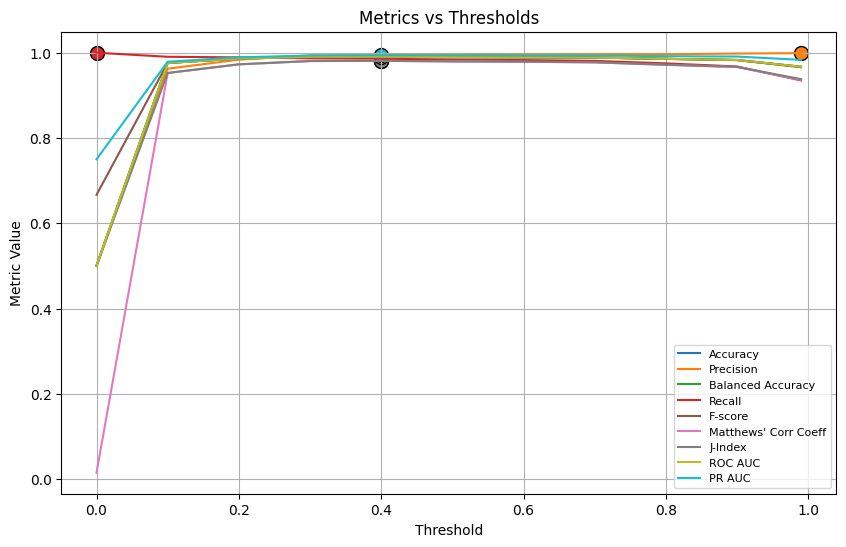

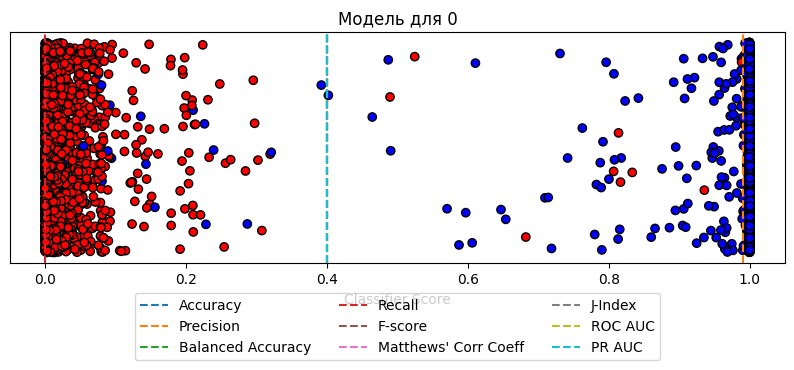

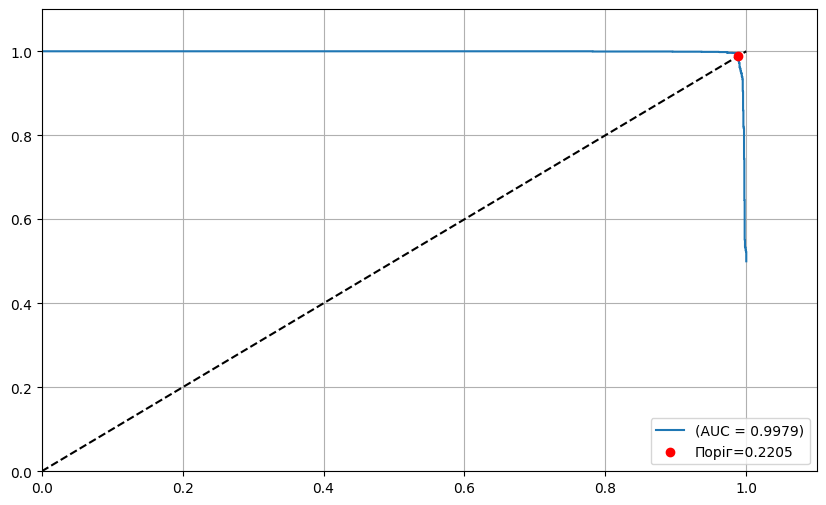

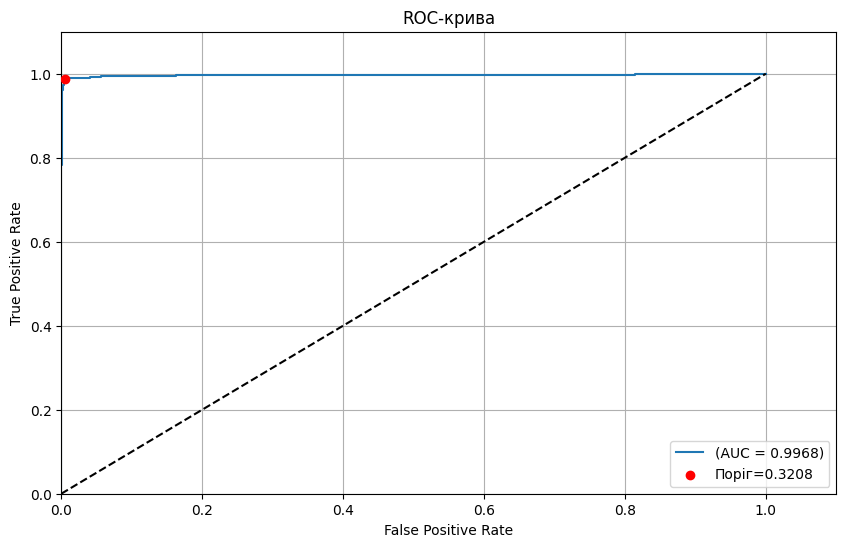

In [163]:
m_1_0 = model_metrics(df['GT'], df["Model_1_0"], 0)


### Не збалансована (7.0)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5196\279626060.py:39: RuntimeWarning: invalid value encountered in scalar divide
  J.append(TP/(TP+FN) + TN/(TN+FP) - 1)


Accuracy: [0.833, 0.983, 0.988, 0.988, 0.987, 0.986, 0.984, 0.983, 0.978, 0.973, 0.946]
Precision: [0.833, 0.99, 0.996, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 1.0, 1.0]
Balanced Accuracy: [0.5, 0.969, 0.984, 0.99, 0.99, 0.989, 0.988, 0.987, 0.984, 0.983, 0.968]
Recall: [1.0, 0.99, 0.989, 0.987, 0.986, 0.984, 0.983, 0.981, 0.975, 0.968, 0.935]
F-score: [0.909, 0.99, 0.992, 0.993, 0.992, 0.991, 0.991, 0.99, 0.987, 0.983, 0.966]
Matthews' Corr Coeff: [0.0, 0.94, 0.956, 0.958, 0.955, 0.951, 0.947, 0.942, 0.927, 0.911, 0.84]
J-Index: [nan, 0.942, 0.943, 0.936, 0.932, 0.924, 0.919, 0.911, 0.887, 0.86, 0.755]
ROC AUC: [0.5, 0.969, 0.984, 0.99, 0.99, 0.989, 0.988, 0.987, 0.984, 0.983, 0.968]
PR AUC: [0.917, 0.994, 0.997, 0.998, 0.998, 0.998, 0.998, 0.998, 0.997, 0.997, 0.995]


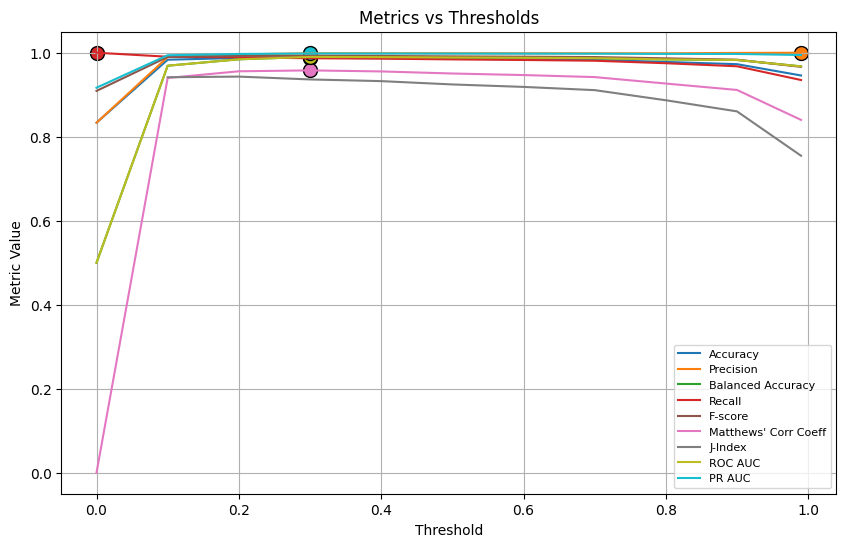

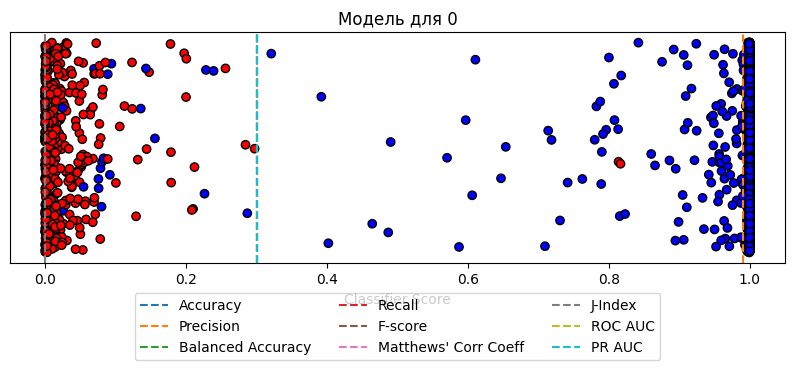

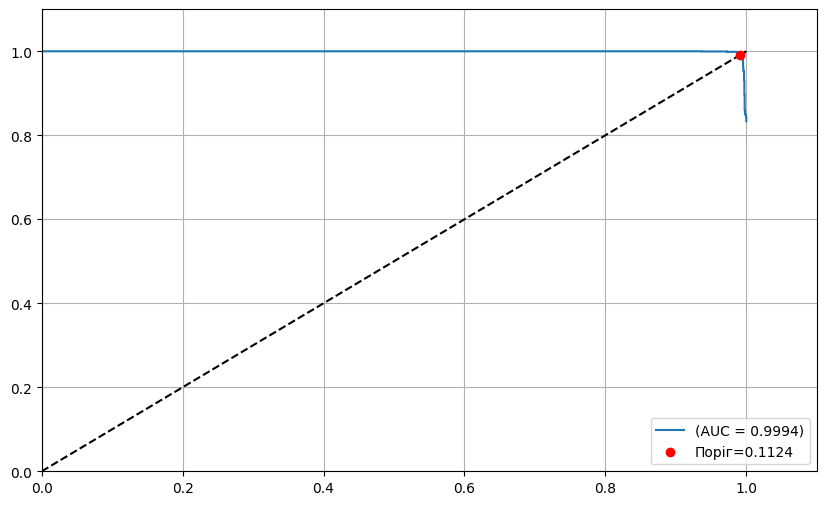

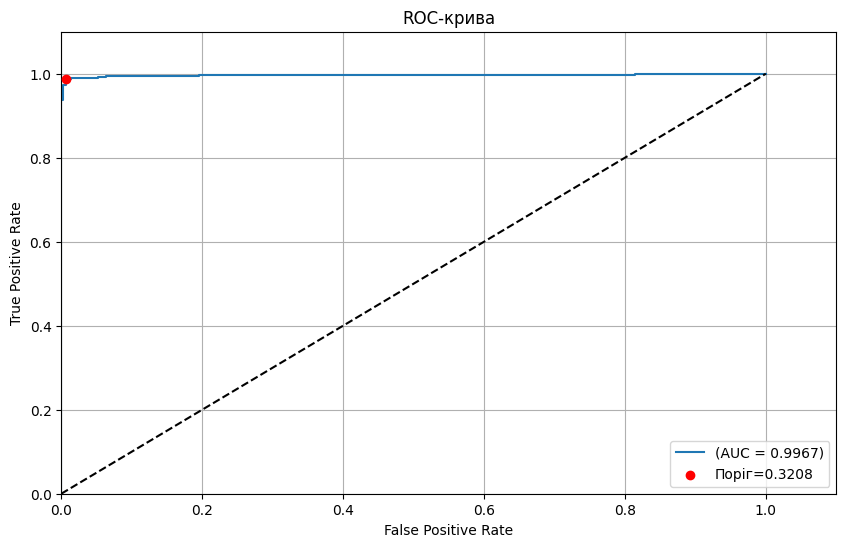

In [162]:
new_m_1_0 = model_metrics(df_unbal['GT'],df_unbal['Model_1_0'], 0)

## **Модель 2 для 1**

### Збалансована (3.1)

Accuracy: [0.54, 0.812, 0.991, 0.991, 0.991, 0.991, 0.992, 0.983, 0.824, 0.824, 0.764]
Precision: [0.521, 0.728, 0.987, 0.987, 0.987, 0.988, 0.99, 0.99, 0.997, 0.997, 0.997]
Balanced Accuracy: [0.54, 0.812, 0.991, 0.991, 0.991, 0.991, 0.992, 0.983, 0.824, 0.824, 0.764]
Recall: [1.0, 0.998, 0.995, 0.995, 0.995, 0.995, 0.995, 0.975, 0.651, 0.651, 0.53]
F-score: [0.685, 0.842, 0.991, 0.991, 0.991, 0.991, 0.992, 0.983, 0.787, 0.787, 0.692]
Matthews' Corr Coeff: [0.205, 0.673, 0.982, 0.982, 0.982, 0.983, 0.984, 0.966, 0.692, 0.692, 0.598]
J-Index: [0.521, 0.724, 0.982, 0.982, 0.982, 0.983, 0.984, 0.966, 0.737, 0.737, 0.677]
ROC AUC: [0.54, 0.812, 0.991, 0.991, 0.991, 0.991, 0.992, 0.983, 0.824, 0.824, 0.764]
PR AUC: [0.76, 0.863, 0.992, 0.992, 0.992, 0.993, 0.993, 0.989, 0.911, 0.911, 0.881]


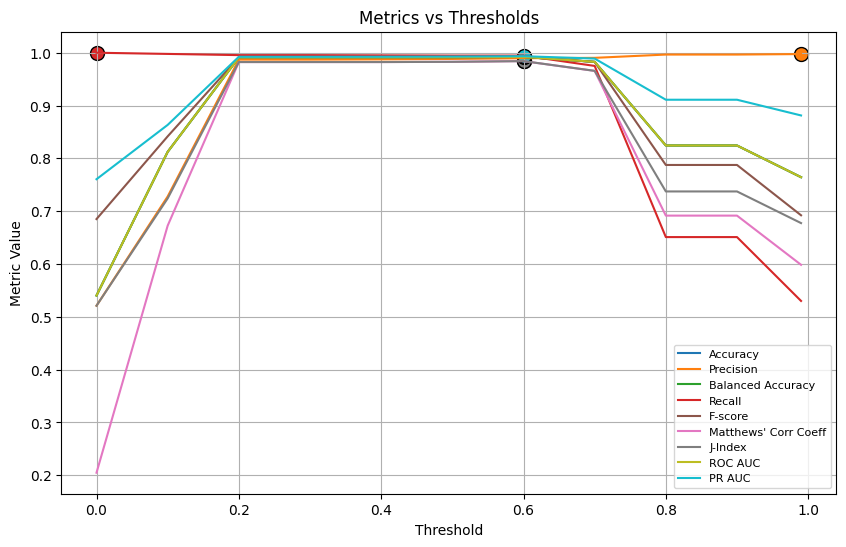

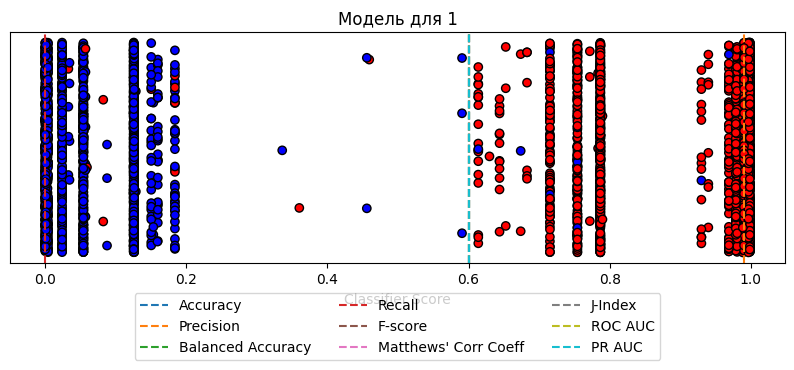

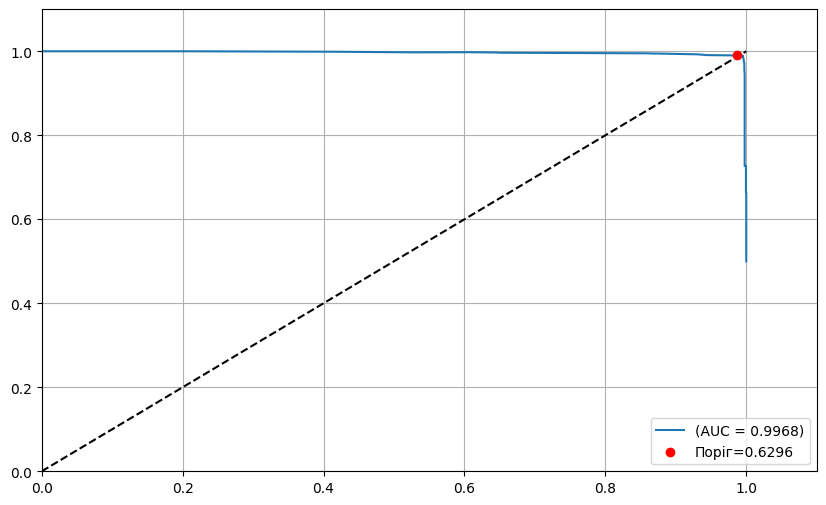

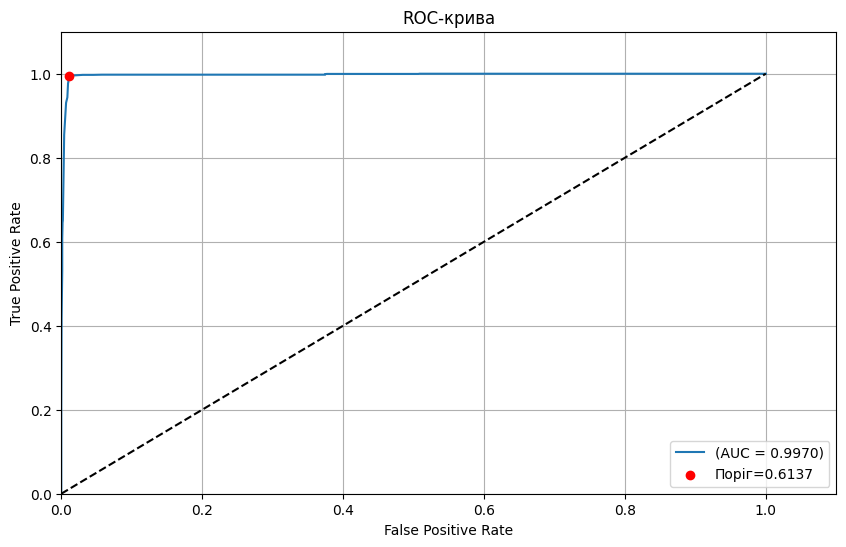

In [150]:
m_2_1 =model_metrics(df['GT'], df["Model_2_1"], 1)

### Не збалансована (7.1)

Accuracy: [0.234, 0.689, 0.988, 0.988, 0.989, 0.989, 0.991, 0.988, 0.944, 0.944, 0.925]
Precision: [0.179, 0.348, 0.938, 0.938, 0.94, 0.944, 0.95, 0.953, 0.983, 0.983, 0.988]
Balanced Accuracy: [0.54, 0.812, 0.991, 0.991, 0.991, 0.992, 0.992, 0.983, 0.835, 0.835, 0.777]
Recall: [1.0, 0.998, 0.995, 0.995, 0.995, 0.995, 0.995, 0.975, 0.673, 0.673, 0.555]
F-score: [0.303, 0.516, 0.966, 0.966, 0.967, 0.969, 0.972, 0.964, 0.799, 0.799, 0.71]
Matthews' Corr Coeff: [0.12, 0.466, 0.959, 0.959, 0.961, 0.963, 0.967, 0.957, 0.786, 0.786, 0.708]
J-Index: [0.179, 0.348, 0.937, 0.937, 0.939, 0.943, 0.949, 0.948, 0.922, 0.922, 0.906]
ROC AUC: [0.54, 0.812, 0.991, 0.991, 0.991, 0.992, 0.992, 0.983, 0.835, 0.835, 0.777]
PR AUC: [0.589, 0.673, 0.967, 0.967, 0.968, 0.97, 0.973, 0.966, 0.855, 0.855, 0.808]


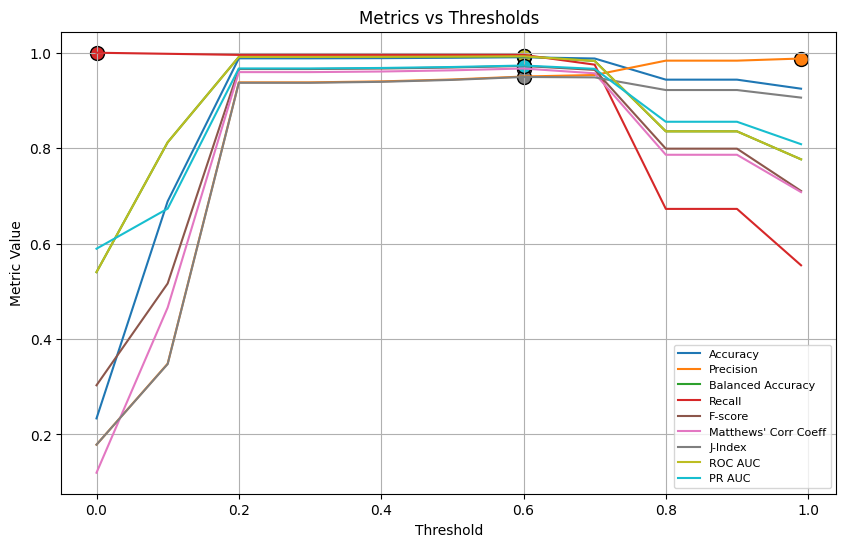

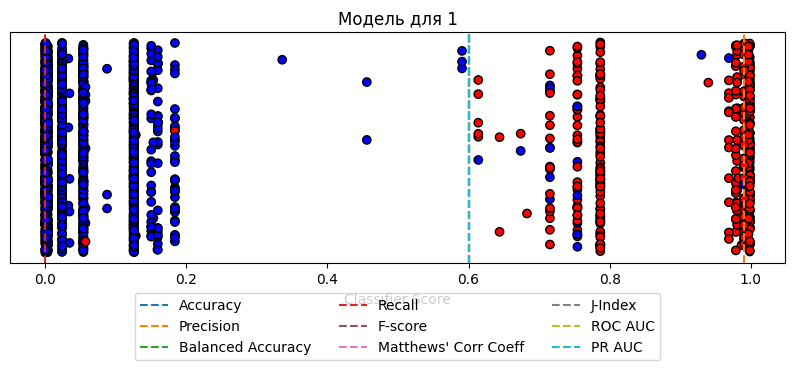

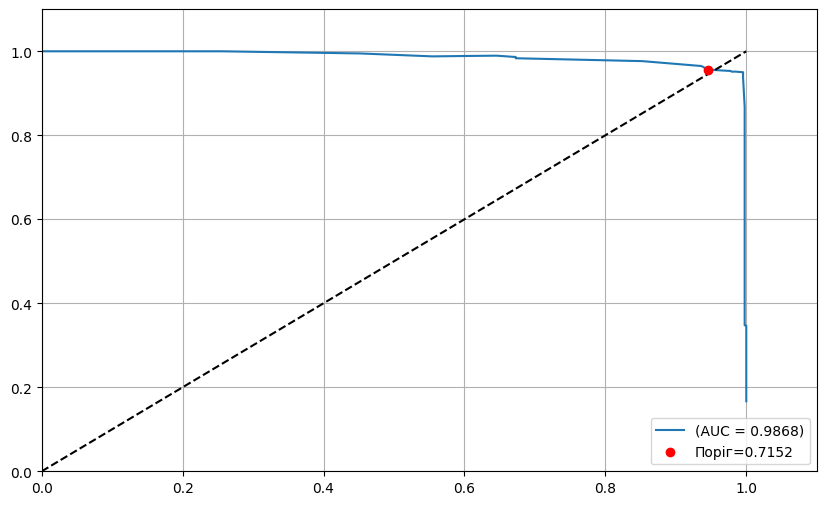

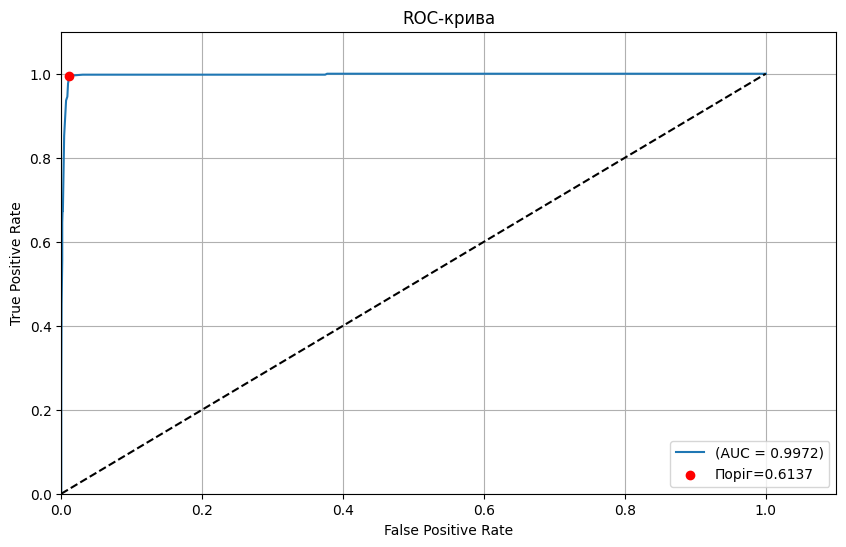

In [151]:
new_m_2_1 = model_metrics(df_unbal['GT'],df_unbal['Model_2_1'], 1)

## Порівняння моделей (4 та 8)

Для першої моделі визначемо найкращий поріг 0.3, для другої 0.6.\
Порівняємо характеристики моделей при найкращих порогах. Можемо стверджувати, що модель 2 більш ефективна при збалансованому наборі данних

In [127]:
compare (m_1_0, 3, m_2_1, 6)

Metric               Model 1    Model 2    Better
--------------------------------------------------
Accuracy             0.9902     0.992      < Model 2
Precision            0.9936     0.9896     Model 1 >
Balanced Accuracy    0.9902     0.992      < Model 2
Recall               0.9868     0.9945     < Model 2
F-score              0.9902     0.9921     < Model 2
Matthews' Corr Coeff 0.9805     0.9841     < Model 2
J-Index              0.9805     0.9841     < Model 2
ROC AUC              0.9902     0.992      < Model 2
PR AUC               0.9935     0.9934     Model 1 >
Threshold            0.3        0.6        < Model 2


Бачимо, що гармонічне точність та повнота краще у моделі 1. Тобто визначення 0 працює краще при суттєвому відкиданні з класу 1. Але все одно модель 2 працює трохи ефективніше навіть при дисбалансі

In [164]:
compare(new_m_1_0, 3, new_m_2_1, 6)

Metric               Model 1    Model 2    Better
--------------------------------------------------
Accuracy             0.9879     0.9905     < Model 2
Precision            0.9986     0.9501     Model 1 >
Balanced Accuracy    0.99       0.9925     < Model 2
Recall               0.9868     0.9955     < Model 2
F-score              0.9927     0.9723     Model 1 >
Matthews' Corr Coeff 0.9579     0.9669     < Model 2
J-Index              0.9364     0.9492     < Model 2
ROC AUC              0.99       0.9925     < Model 2
PR AUC               0.9982     0.9732     Model 1 >
Threshold            0.3        0.6        < Model 2


## Використані джерела:


* https://www.geeksforgeeks.org/sklearn-classification-metrics/
* https://www.kaggle.com/code/pythonafroz/evaluation-metrics-used-in-machine-learning
* https://www.kaggle.com/code/nicholasgah/optimal-probability-thresholds-using-pr-curve